# Analyze Data / Produce paper figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import scipy.stats
import seaborn as sns
import SD_functions as SDF
from scipy.optimize import minimize, minimize_scalar
import statsmodels.formula.api as smf

pi=np.pi
xx = np.linspace(-pi,pi,180)
n_bns=32
bns = np.linspace(-pi,pi,n_bns)
bns[0] -=1E-6
bns[-1] +=1E-6
d_bns = np.linspace(-180,180,n_bns)
overlap = 3
r2d,d2r = 180/pi,pi/180
pm = np.array((-1,1))

cols = sns.color_palette('Paired',4)

def mean_stats(x):
    this_t = scipy.stats.ttest_1samp(x,0)
    print('%.2f \u00B1 %.2f (n=%d) t=%.3f (p=%.6f)' %(np.mean(x),np.std(x)/np.sqrt(len(x)),len(x),*this_t))
task_map = {'v4':'expt1','v3':'expt1b','v5':'expt2','v8':'expt4','expt3':'expt3'}

def sem(x): return np.std(x)/np.sqrt(len(x))

bnds_vm = (15*pm*d2r,(.1,10))#,pm*10*d2r)

cols_keep = ['compass','trial','subj_t','corrected_E','good','RT','drop_trials','delay','hide_trial','stimG','task']

DO_SHUFFLE = False

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_fit(vals):
    this_fit_vm = scipy.optimize.minimize(loss_fun_vm,x0_vm,vals,bounds=bnds_vm)
    return this_fit_vm.x,this_fit_vm.success

def get_this_S(): # reliant on global variables
    _this_S = S.loc[:,cols_keep].copy().reset_index(drop=True) # which variables being used?
    if DO_SHUFFLE: _this_S = _this_S.reindex(np.random.permutation(_this_S.index))
    _this_S['d_ori'] = SDF.get_nb(nb,S.stim.values)
    _this_S['d_correct'] = SDF.get_nb(nb,S.correct_resp.values)
    _this_S['drop_prev'] = SDF.get_nb(nb,S.drop_trials.values,0)
    _this_S['no_drop']   = (S.drop_trials.values==0)#&(drop_prev==0) # not true drop on prev trial
    _this_S['compass_prev'] = SDF.get_nb(nb,S.compass.values,0)
    _this_S['d_dummy'] = SDF.wrapRad(SDF.get_nb(nb,S.dummy_angle.values,0)-S.correct_resp.values)
    _this_S['hide_trial_prev'] = SDF.get_nb(nb,S.hide_trial.values,0)
    prev_E = SDF.get_nb(nb,S.corrected_E,0)
    _this_S['d_resp'] = SDF.wrapRad(_this_S['d_ori'] + prev_E)
    return _this_S

def get_curve_estimates(vals):
    _bias = SDF.do_bining(bns,overlap,*vals,want_var='circ_mean')*r2d
    _sd = SDF.do_bining(bns,overlap,*vals,want_var='circ_var')
    return _bias,_sd


In [3]:
# set font size
def sav_fig(nam):
    root = './Figures_v1/'
    plt.savefig(root + nam +'.svg',dpi=1200)
plt.rcParams.update({'font.size': 14
                    })

# load data

In [4]:
data = pd.read_parquet('data/data_preprocessed_16p_correction.parquet')

# Figures 1-2, S2
- DoG curves for task condtions
- bar plot for effect magnitude

In [5]:
S = data
min_trials = 30
tasks = ['v3','v4','v5','v8']

# special subset of first n subjects for very paricular control analysis
s_use = []
for task in tasks:
    this_d = S.query('task==@task')
    these_s = this_d.subj_t.unique()[:19]
    s_use.append(these_s)
s_use = np.concatenate(s_use)

max_E = (30*d2r)

# nb_want = np.arange(-1,-2,-1)

good = (~np.isnan(S.E.values))&(np.abs(S.E.values)<max_E)#&(S.drop_trials.values==0)
S['good'] = good

card_ori = sorted(S.stimG.unique())[::8]


In [6]:
LOAD_FITS = True # save time running models
nb_want =  [*np.arange(-1,-7,-1),(-5,-1)]
loss_fun_vm = SDF.rss_fun(SDF.Sd_vm)
x0_vm = (0,1)

In [7]:
if LOAD_FITS:
    print('Loading pre-fit models for continuous report experiments')
    fits_all = pd.read_parquet('data/fits_all_CR.parquet')
else:

    subjs_use = list(S.subj_t.unique())
    n_subj = len(subjs_use)
    n_shuf = 100


    subjs_use += [f'POOL_{task}' for task in tasks]
    subjs_use += [f'POOL_RAND_{task}' for task in tasks for i in range(n_shuf)]


    n_nb = len(nb_want)

    card_ori = sorted(S.stimG.unique())[::8]


    fits_all = pd.DataFrame()
    this_query = ('subj_t==@subj & good & drop_trials==0 & trial>=-@nb & (drop_prev in @dp) & compass!=@comp & compass_prev!=@comp_prev & corrected_E.notnull()')
    this_query_pool = ('task==@this_task & good & drop_trials==0 & trial>=-@nb & (drop_prev in @dp) & compass!=@comp & compass_prev!=@comp_prev & corrected_E.notnull()')

    query_no_hist = 'subj_t==@subj & good & compass==@ci & drop_trials==0'
    query_no_hist_pool = 'task==@this_task & good & compass==@ci & drop_trials==0'

    for si,subj in enumerate(subjs_use):
        if np.mod(si,5)==0: print(subj)
        this_task = subj[-2:]

        is_pool = subj[:4]=='POOL'
        if is_pool:
            this_query_now, this_query_hist = query_no_hist_pool, this_query_pool
            DO_SHUFFLE = subj[5:9]=='RAND'
        else:
            this_query_now,this_query_hist = query_no_hist, this_query    
            DO_SHUFFLE=False

        for ci in range(2):      
            # dont do shuffle for nb=0
            if DO_SHUFFLE:
                continue
            vals_stim = S.query(this_query_now).loc[:,['stim','corrected_E']].values.T
            slide_bias,slide_var = get_curve_estimates(vals_stim)

            vals_dummy = S.query(this_query_now).loc[:,['stim','dummy_angle','corrected_E']].values.T
            vals = (SDF.wrapRad(vals_dummy[1]-vals_dummy[0]),vals_dummy[2])
            this_coef_dummy,_ = get_fit(vals)
            slide_bias_dummy,slide_var_dummy = get_curve_estimates(vals)

            fits_all = fits_all.append({'subj':subj,'task':this_task,'nb':0,'nb_str':'0','compass_prev':'both',
                                                    'compass':['dot','comp','both'][ci],'amp_dummy':this_coef_dummy[0]*r2d,'n_trials':len(vals_dummy[0]),
                                                    'slide_bias':slide_bias,'slide_var':slide_var,
                                                    'slide_bias_dummy':slide_bias_dummy,'slide_var_dummy':slide_var_dummy,'pool':is_pool,'shuffle':DO_SHUFFLE
                                                   },ignore_index=1)


        for nbi,_nb in enumerate(nb_want):

            if (type(_nb) is tuple) : # expect nb_want entries to be ranges...
                __this_S = []
                for nb in np.arange(*_nb):
                    _this_S = get_this_S()
                    __this_S.append(_this_S)
                this_S = pd.concat(__this_S).reset_index()
                nb = np.min(nb)
                nb_str = f'{_nb[0]}-{_nb[1]}'
            else:
                nb = _nb
                nb_str = str(nb)
                this_S = get_this_S()

            for ci,comp in enumerate([1,0,2]):
                for cp,comp_prev in enumerate([1,0,2]):
                    for dpi, dp in enumerate([(0,),(1,)]): # current excluding flip... include?

                        Su = this_S.query(this_query_hist, engine='python')

                        n_inc = len(Su)
                        if n_inc<min_trials:
                            continue
                        if (this_task=='v3') & ((ci!=cp) & ((ci<2)|(cp<2))):
                            continue

                        vals = tuple(Su.loc[:,['d_ori','corrected_E']].values.T)
                        vals_dummy = tuple(Su.loc[:,['d_dummy','corrected_E']].values.T)

                        this_acc = SDF.circ_var(vals[1])

                        slide_bias,slide_var = get_curve_estimates(vals)
                        slide_bias_dummy,slide_var_dummy = get_curve_estimates(vals_dummy)

                        this_coef,_ = get_fit(vals)
                        this_coef_dummy,_ = get_fit(vals_dummy)

                        fits_all = fits_all.append({'subj':subj,'task':this_task,'nb':-nb,'nb_str':nb_str,'compass_prev':['dot','comp','both'][cp],
                                                    'compass':['dot','comp','both'][ci],'ampVM':this_coef[0]*r2d,
                                                    'wVM':this_coef[1],#'bVM':this_coef[2],
                                                    'amp_dummy':this_coef_dummy[0]*r2d,'n_trials':n_inc,
                                                    'drop_prev':dpi,'circ_sd':this_acc,
                                                    'slide_bias':slide_bias,'slide_var':slide_var,
                                                    'slide_bias_dummy':slide_bias_dummy,'slide_var_dummy':slide_var_dummy,'pool':is_pool,'shuffle':DO_SHUFFLE
                                                   },ignore_index=1)

    fits_all['condition'] = fits_all.compass_prev.values + '->' + fits_all.compass.values
    DO_SHUFFLE = False

    duplicate_v3 = fits_all.query('task=="v3" & nb_str!="0"').copy()
    duplicate_v3['compass_prev'] = 'both'
    duplicate_v3['condition'] = duplicate_v3.compass_prev.values + '->' + duplicate_v3.compass.values
    fits_all = pd.concat((fits_all,duplicate_v3))

    # save out 
    # fits_all.to_parquet('data/fits_all_CR.parquet')

Loading pre-fit models for continuous report experiments


# Load 2AFC data

In [8]:
fits_expt3 = pd.read_parquet('data/fits_expt3.parquet')
fits_merge = pd.concat([fits_all, fits_expt3])

# Figure 1 - task conditions!
- only for task_v4
- only for non-drop current
- split by drop prev
- no split by compass type

In [9]:
subjs_use = S.query('task=="v4"').subj_t.unique()
n_subj = len(subjs_use)

nb = -1
this_query = 'subj_t==@subj & good & trial>=-@nb & (drop_prev == @dp) & corrected_E.notnull() & drop_trials==0 & compass!=@comp & compass_prev!=@comp_prev'

this_S = get_this_S()
fit_v4 = pd.DataFrame()
for si,subj in enumerate(subjs_use):
    for ci,comp in enumerate([1,0,2]):
        for cp,comp_prev in enumerate([1,0,2]):
            for dpi, dp in enumerate([0,2,3]):

                Su = this_S.query(this_query, engine='python')

                n_inc = len(Su)

                vals = tuple(Su.loc[:,['d_ori','corrected_E']].values.T)
                vals_correct = tuple(Su.loc[:,['d_correct','corrected_E']].values.T)


                slide_bias,slide_var = get_curve_estimates(vals)
                slide_bias_correct,slide_var_correct = get_curve_estimates(vals_correct)

                this_coef,_ = get_fit(vals)
                this_coef_correct,_ = get_fit(vals_correct)
                this_acc= SDF.circ_var(vals[1])*r2d
                this_rt = np.nanmedian(Su.RT)

                fit_v4 = fit_v4.append({'subj':subj,'nb':-nb,'compass_prev':['dot','comp','both'][cp],
                                            'compass':['dot','comp','both'][ci],
                                            'ampVM':this_coef[0]*r2d,
                                            'wVM':this_coef[1],#'bVM':this_coef[2],
                                            'amp_correct':this_coef_correct[0]*r2d,
                                            'w_correct':this_coef_correct[1],
                                            'n_trials':n_inc,
                                            'drop_prev':dpi,'circ_sd':this_acc,
                                            'slide_bias':slide_bias,'slide_var':slide_var,
                                            'slide_bias_correct':slide_bias_correct
                                           },ignore_index=1)

        

drop:0 [1.25+/-0.121]	 t(18)=10.1 (p=8.169e-09)
drop:0 [1.25+/-0.121]	 t(18)=10.1 (p=8.169e-09)

drop:1 [0.178+/-0.25]	 t(18)=0.693 (p=0.4974)
drop:1 [1.37+/-0.205]	 t(18)=6.48 (p=4.307e-06)

drop:2 [-0.15+/-0.292]	 t(18)=-0.499 (p=0.6239)
drop:2 [1.69+/-0.342]	 t(18)=4.82 (p=0.0001383)



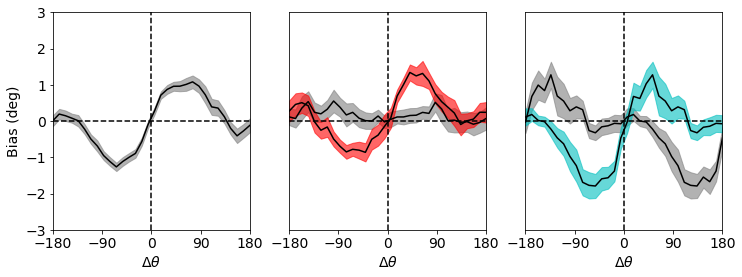

In [10]:
# can now expand out to other statistics when wanted...
comp_prev = 'both'
comp = 'both'
# allow bonus stats when breaking out by compass condition.
gen_query = 'drop_prev==@dp & compass_prev==@comp_prev & compass==@comp'
plt.figure(figsize=(12,4))

col2 = ('gray','r','c')
for dpi,dp in enumerate([0,1,2]): # drop prev
    
    plt.subplot(1,3,dpi+1)

    this_query = gen_query
    this_d = fit_v4.query(this_query)
    N = len(this_d)
    if N==0:
        ii+=1
        continue
    this_bias_stack = np.stack(this_d.slide_bias)
    this_bias_correct_stack = np.stack(this_d.slide_bias_correct)
    SDF.sem_plot(d_bns,this_bias_stack ,alpha=.6,color='gray',do_line=1)
    if dpi>0:
        this_col = col2[dpi]
        SDF.sem_plot(d_bns,this_bias_correct_stack ,alpha=.6,color=this_col,do_line=1)
    
#     this_amp
    SDF.d_plot(1,3)
    plt.xlabel('$\Delta\\theta$')
    if dpi==0:
        plt.ylabel('Bias (deg)')
    else:
        plt.yticks([])
        
    this_amp = this_d.ampVM.values
    this_amp_correct = this_d.amp_correct.values
    stat_amp = scipy.stats.ttest_1samp(this_amp,0)
    stat_amp_correct = scipy.stats.ttest_1samp(this_amp_correct,0)
    print(f'drop:{dpi} [{np.mean(this_amp):.3}+/-{sem(this_amp):.3}]\t t({len(this_amp)-1})={stat_amp[0]:.3} (p={stat_amp[1]:.4})')
    print(f'drop:{dpi} [{np.mean(this_amp_correct):.3}+/-{sem(this_amp_correct):.3}]\t t({len(this_amp_correct)-1})={stat_amp_correct[0]:.3} (p={stat_amp_correct[1]:.4})')
    print()
#     sav_fig('Figure1_drop_condition')

# (extra) do stats for response type for all combinations of stimuli

In [11]:

comp_prev = "both"
comp = "both"
gen_query_0 = 'compass_prev==@comp_prev & compass==@comp & drop_prev==@dp'
for comp_prev in ('dot','comp','both'):
    for dp in range(3):
        this_d = fit_v4.query(gen_query_0)
        these_amps = this_d.loc[:,['ampVM','amp_correct']].values.T
        stats_stim = scipy.stats.ttest_1samp(these_amps[0],0)
        stats_correct = scipy.stats.ttest_1samp(these_amps[1],0)
        print(f'drop{dp} stim type: {comp_prev} stim {stats_stim[1]:.3}\t correct {stats_correct[1]:.3}')
    print()
    

drop0 stim type: dot stim 4.79e-07	 correct 4.79e-07
drop1 stim type: dot stim 0.714	 correct 0.0214
drop2 stim type: dot stim 0.961	 correct 0.000331

drop0 stim type: comp stim 9.11e-07	 correct 9.11e-07
drop1 stim type: comp stim 0.953	 correct 5.94e-08
drop2 stim type: comp stim 0.417	 correct 0.00026

drop0 stim type: both stim 8.17e-09	 correct 8.17e-09
drop1 stim type: both stim 0.497	 correct 4.31e-06
drop2 stim type: both stim 0.624	 correct 0.000138



# Expt 1: Get acc and RT by condition (Figure S4)

In [12]:
this_S = S.query('task=="v4" & good').copy()
this_S.subj_t = this_S.subj_t.cat.remove_unused_categories()
acc_condition = this_S.groupby(['subj_t','drop_trials']).E.apply(lambda x: np.std(x)*r2d).reset_index()
rt_condition = this_S.groupby(['subj_t','drop_trials']).RT.apply(lambda x: np.median(x)).reset_index()

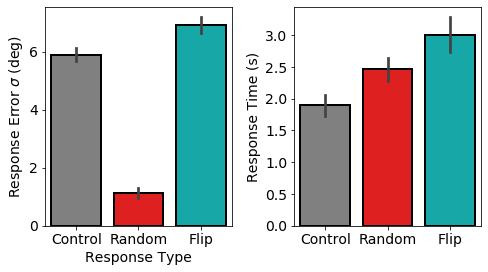

In [13]:
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
sns.barplot(data=acc_condition,x='drop_trials',y='E',ci=68,palette=col2,edgecolor='k',linewidth=2)
plt.ylabel('Response Error $\sigma$ (deg)')
plt.xlabel('Response Type')
plt.xticks([0,1,2],['Control','Random','Flip'])

plt.subplot(1,2,2)
sns.barplot(data=rt_condition,x='drop_trials',y='RT',ci=68,palette=col2,edgecolor='k',linewidth=2)
plt.ylabel('Response Time (s)')
plt.xlabel('')
plt.xticks([0,1,2],['Control','Random','Flip'])
plt.tight_layout()
# sav_fig('Figure S3')
plt.show()



In [14]:
vals = (acc_condition.query('drop_trials==0').E.values,
        acc_condition.query('drop_trials==3').E.values)
print(scipy.stats.ttest_rel(*vals))
print()

md = smf.mixedlm('RT~C(drop_trials)', data=rt_condition,groups=rt_condition['subj_t']).fit()
md.summary()

Ttest_relResult(statistic=-5.928495301632378, pvalue=1.3051653986793848e-05)



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   RT      
No. Observations:     57        Method:               REML    
No. Groups:           19        Scale:                0.2680  
Min. group size:      3         Likelihood:           -65.0841
Max. group size:      3         Converged:            Yes     
Mean group size:      3.0                                     
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             1.896    0.226 8.402 0.000  1.453  2.338
C(drop_trials)[T.2.0] 0.567    0.168 3.376 0.001  0.238  0.896
C(drop_trials)[T.3.0] 1.108    0.168 6.596 0.000  0.779  1.437
Group Var             0.699    0.622                          
==============================================================

"""

# Figure 2 + stats

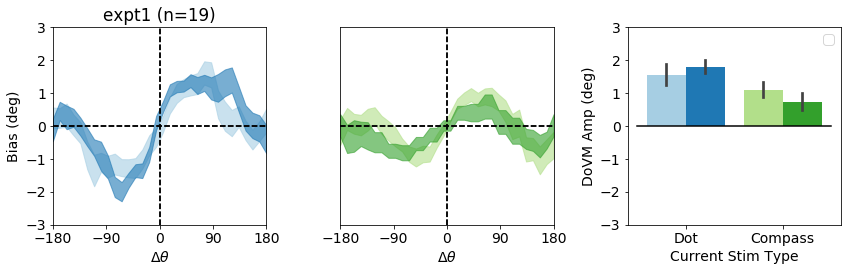

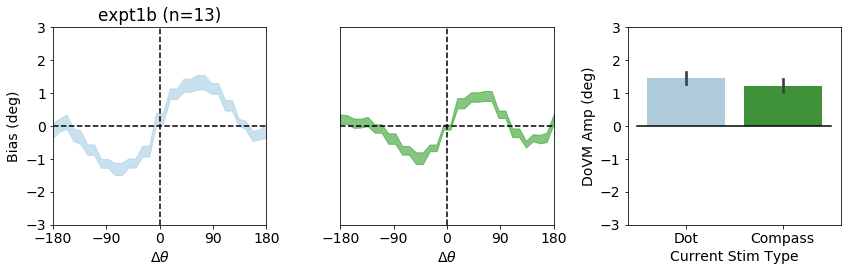

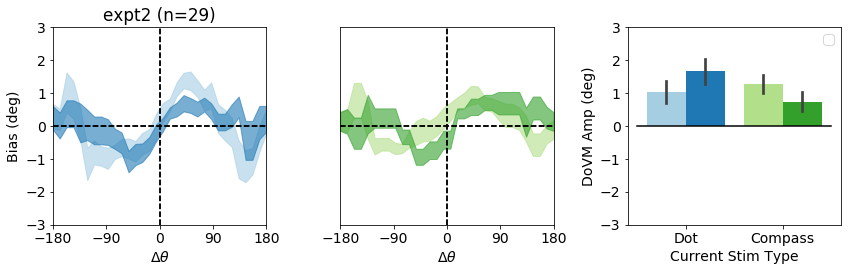

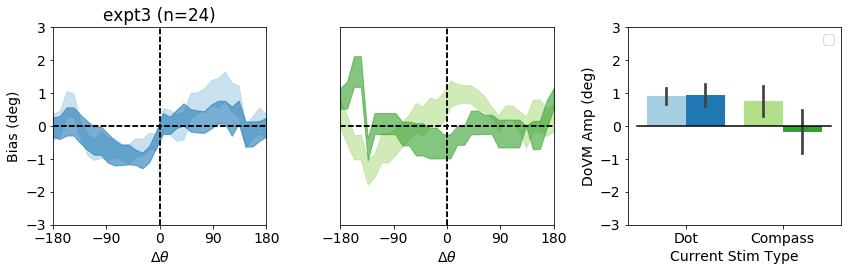

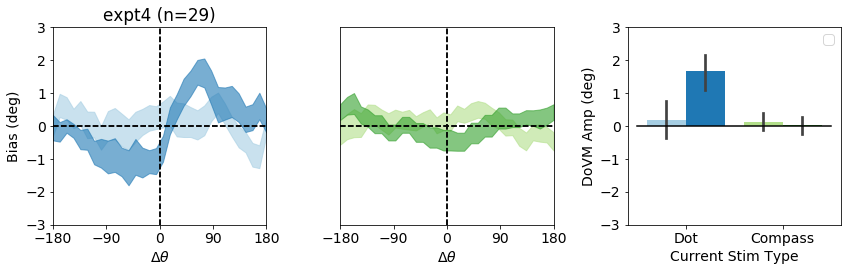

In [15]:
shuf=0
view_shuf = 0
dp=0
dc=0 # drop current
nbi=0
nb = str(nb_want[nbi])
y_var_plt = 'ampVM'
show_pool = False # flag - overlay pooled results?

task_order = [ 'v4','v3', 'v5','expt3', 'v8']

for this_task in task_order:
    task_label = task_map.get(this_task,this_task)
    ii=0
    gen_query = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass!="both" & compass_prev!="both" & pool==False & shuffle==False'
    gen_query_pool = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass!="both" & compass_prev!="both" & pool==True & shuffle==False'
    plt.figure(figsize=(12,4))
    for ci,comp in enumerate(('dot','comp')):
        plt.subplot(1,3,ci+1)
        for cpi, comp_prev in enumerate(('dot','comp')):
            this_query = gen_query + ' & compass==@comp & compass_prev==@comp_prev'
            this_query_pool = gen_query_pool + ' & compass==@comp & compass_prev==@comp_prev'
            
            this_d = fits_merge.query(this_query)
            this_d_pool = fits_merge.query(this_query_pool)
            N = len(this_d)
            if N==0:
                ii+=1
                continue
            this_bias_stack = np.stack(this_d.slide_bias)
            lab = f'{comp_prev} --> {comp}'

            SDF.sem_plot(d_bns,this_bias_stack,label = lab ,alpha=.6,color=cols[ii])
            if show_pool:
                plt.plot(d_bns,this_d_pool.slide_bias.iloc[0],color=np.array(cols[ii])-.1)
            SDF.d_plot(1,3)
            if ci==0:
                plt.ylabel('Bias (deg)')
                plt.title(f'{task_label} (n={N})')
            else:
                plt.yticks([])

            plt.xlabel('$\Delta\\theta$')
            ii+=1
            
    plt.subplot(1,3,3)
    this_d = fits_merge.query(gen_query)
    this_d_pool = fits_merge.query(gen_query_pool)
    pool_vals = this_d_pool.ampVM.values
    if this_task=='v3':
        ax = sns.barplot(data=this_d, # &(fits_all.isShuf==shuf)
                x='compass',y=y_var_plt,palette=cols[::3],ci=68)
        plt.plot([-.5,1.5],[0,0],'k')
        
        bar_x_loc = sorted([p.xy[0]+.4 for p in ax.patches])
        if show_pool:
            plt.plot(bar_x_loc,pool_vals,'ko',markeredgecolor='k', markerfacecolor='None',markersize=10)
    else:
        ax = sns.barplot(data=this_d,
                    hue='compass_prev',y=y_var_plt,x='compass',palette=cols[::2],ci=68) # &(fits_all.isShuf==shuf),errorbar=eb
        
        bar_x_loc = sorted([p.xy[0]+.2for p in ax.patches])

        if show_pool:
            plt.plot(bar_x_loc,pool_vals,'ko',markeredgecolor='k', markerfacecolor='None',markersize=10)

        plt.plot([-.5,1.5],[0,0],'k')
        plt.legend('')
        bi=0
        for bars in ax.containers:
            for bar, color in zip(bars, cols[bi::2]):
                    bar.set_facecolor(color)
            bi+=1

    plt.ylabel('DoVM Amp (deg)')
    plt.xticks([0,1],['Dot','Compass'])
    plt.xlabel('Current Stim Type')

    plt.ylim(-3,3)

    plt.tight_layout()
#     sav_fig(f'Joint_nb1_basic_{this_task}_subj_pool')
    plt.show()



In [16]:
nb="-1"
dp=0
task_order = [ 'v4','v3', 'v5','expt3', 'v8']
for this_task in task_order:
    task_label = task_map.get(this_task,this_task)
    ii=0
    gen_query = 'task==@this_task'
    this_study = fits_merge.query(gen_query)
    n_trials = len(this_study)
    n_subj = this_study.subj.nunique()
    
    print(f'{task_label} {n_trials} trials {n_subj} participants')
    
    this_query = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass==@comp & compass_prev==@comp_prev & pool==False'
    for ci,comp in enumerate(('dot','comp')):
        for cpi, comp_prev in enumerate(('dot','comp','both')):
            this_d = fits_merge.query(this_query)
            if len(this_d)<=1:
                continue
            this_amp = this_d.ampVM
            df = len(this_amp)-1
            this_stat = scipy.stats.ttest_1samp(this_amp,0)
            print(f'{task_label} {comp_prev}->{comp}\t {np.mean(this_amp):.3}+/-{sem(this_amp):.3}\t t({df})={this_stat[0]:.2} (p={this_stat[1]:.4})')
            if (comp_prev=='both') or (this_task=='v3'):
                if comp=='dot':
                    save0 = this_amp
                else:
                    this_stat = scipy.stats.ttest_rel(save0,this_amp)
                    print(f'{task_label}  compare\t t({df})={this_stat[0]:.2} (p={this_stat[1]:.4})')
    print()
            
            

expt1 13900 trials 21 participants
expt1 dot->dot	 1.54+/-0.32	 t(18)=4.7 (p=0.0001846)
expt1 comp->dot	 1.79+/-0.208	 t(18)=8.4 (p=1.204e-07)
expt1 both->dot	 1.69+/-0.182	 t(18)=9.1 (p=4.008e-08)
expt1 dot->comp	 1.1+/-0.229	 t(18)=4.7 (p=0.0001882)
expt1 comp->comp	 0.732+/-0.267	 t(18)=2.7 (p=0.01573)
expt1 both->comp	 0.798+/-0.22	 t(18)=3.5 (p=0.00236)
expt1  compare	 t(18)=3.0 (p=0.007535)

expt1b 4728 trials 15 participants
expt1b dot->dot	 1.46+/-0.179	 t(12)=7.9 (p=4.487e-06)
expt1b comp->comp	 1.22+/-0.199	 t(12)=5.9 (p=7.426e-05)
expt1b  compare	 t(12)=0.95 (p=0.3598)

expt2 16018 trials 31 participants
expt2 dot->dot	 1.67+/-0.376	 t(26)=4.4 (p=0.0001867)
expt2 comp->dot	 1.04+/-0.334	 t(28)=3.1 (p=0.004753)
expt2 both->dot	 1.04+/-0.26	 t(28)=3.9 (p=0.0005157)
expt2 dot->comp	 0.737+/-0.307	 t(28)=2.4 (p=0.02538)
expt2 comp->comp	 1.28+/-0.257	 t(25)=4.9 (p=5.375e-05)
expt2 both->comp	 0.97+/-0.157	 t(28)=6.1 (p=1.556e-06)
expt2  compare	 t(28)=0.22 (p=0.8277)

expt3 1055

## Stats - Randomization on pooled data

In [17]:
nb="-1"
dp=0
task_order = [ 'v4','v3', 'v5','expt3', 'v8']
for this_task in task_order:
    task_label = task_map.get(this_task,this_task)
    ii=0

    
    this_query = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass==@comp & compass_prev==@comp_prev & pool==True & shuffle==False'
    this_query_shuf = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass==@comp & compass_prev==@comp_prev & pool==True & shuffle==True'
    
    for ci,comp in enumerate(('dot','comp')):
        for cpi, comp_prev in enumerate(('dot','comp','both')):
            try:
                this_amp = fits_merge.query(this_query).ampVM.values[0]
                shuf_d = fits_merge.query(this_query_shuf).ampVM.values
                this_p = np.mean(np.abs(shuf_d)>this_amp)*2
                this_z = (this_amp-np.mean(shuf_d))/np.std(shuf_d)
        #             this_stat = scipy.stats.ttest_1samp(this_amp,0)
                print(f'{task_label} {comp_prev}->{comp}\t {this_amp:.2f}\t z={this_z:.2f} (p={this_p})')
            except:
                pass

    print()
            
            

expt1 dot->dot	 1.50	 z=9.00 (p=0.0)
expt1 comp->dot	 1.74	 z=9.91 (p=0.0)
expt1 both->dot	 1.64	 z=13.84 (p=0.0)
expt1 dot->comp	 1.03	 z=6.81 (p=0.0)
expt1 comp->comp	 0.57	 z=3.10 (p=0.02)
expt1 both->comp	 0.82	 z=7.45 (p=0.0)

expt1b dot->dot	 1.43	 z=8.73 (p=0.0)
expt1b comp->comp	 0.95	 z=4.87 (p=0.0)

expt2 dot->dot	 1.14	 z=5.49 (p=0.0)
expt2 comp->dot	 0.87	 z=4.60 (p=0.0)
expt2 both->dot	 0.99	 z=7.58 (p=0.0)
expt2 dot->comp	 0.71	 z=3.78 (p=0.0)
expt2 comp->comp	 0.85	 z=4.37 (p=0.0)
expt2 both->comp	 0.72	 z=5.82 (p=0.0)

expt3 dot->dot	 0.99	 z=4.12 (p=0.0)
expt3 comp->dot	 0.92	 z=4.07 (p=0.0)
expt3 both->dot	 0.94	 z=5.97 (p=0.0)
expt3 dot->comp	 0.64	 z=2.05 (p=0.08)
expt3 comp->comp	 0.75	 z=2.48 (p=0.04)
expt3 both->comp	 0.98	 z=4.03 (p=0.0)

expt4 dot->dot	 0.46	 z=1.69 (p=0.18)
expt4 comp->dot	 1.60	 z=6.07 (p=0.0)
expt4 both->dot	 1.03	 z=6.24 (p=0.0)
expt4 dot->comp	 0.08	 z=0.48 (p=1.34)
expt4 comp->comp	 0.08	 z=0.46 (p=1.08)
expt4 both->comp	 0.08	 z=0.72 (p=

In [18]:
# mixed effects model for for comparing DoVM amplitude given previous stimulus type
nb_str = '-1'
dp=0
this_task = tasks[1]
this_query = 'task==@this_task & nb_str==@nb & drop_prev==@dp & compass_prev!="both" & compass!="both" & pool==False'

this_d = fits_all.query(this_query)
md = smf.mixedlm("ampVM~compass_prev * compass",this_d,groups=this_d['subj']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                    MixedLM        Dependent Variable:        ampVM    
No. Observations:         76             Method:                    REML     
No. Groups:               19             Scale:                     1.2821   
Min. group size:          4              Likelihood:                -118.7875
Max. group size:          4              Converged:                 Yes      
Mean group size:          4.0                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.732    0.267  2.744 0.006  0.209  1.255
compass_prev[T.dot]                 0.370    0.367  1.008 0.314 -0.350  1.090
compass[T.dot]                      1.063    0.367  2.893 0.004  0.343  1.783
compass_prev[T.dot]:compass[T.dot] -0.625    0.520 -1.202 0.229 -1.643  0.394
Group Var                           0.071    0.133                           
=============================================================================

"""

# Figure 3

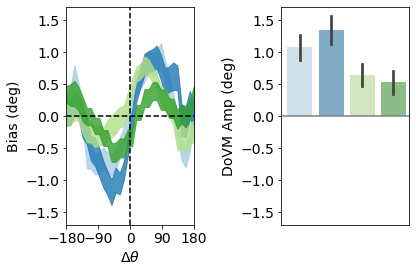

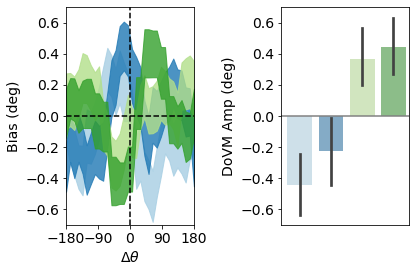

In [19]:
nb='-1'
yl=1.7
yls = (1.7,.7)
xl0,xl1 = ([-.6,3.5],[-.6,3.5])
dp,var_view =  0, 'ampVM'
order_base =  ['dot->dot','comp->dot','dot->comp','comp->comp']

query_use = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str==@nb_str & pool==False '
query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str==@nb_str & pool==False & condition==@cond'

for i,nb_str in enumerate(('-1','-3')): # '-5--1'
    yl = yls[i]
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    for ci,cond in enumerate(['dot->dot','comp->dot','dot->comp','comp->comp']):
        this_d = fits_merge.query(query_0)
        this_bias = np.stack(this_d.slide_bias)
        SDF.sem_plot(bns*r2d,this_bias,color=cols[ci],alpha=.8)
    SDF.d_plot(1,yl)
    plt.xlabel('$\Delta\\theta$')


#     plt.yticks([])
    plt.ylabel('Bias (deg)')
        
    plt.subplot(1,2,2)
    sns.barplot(data=fits_merge.query(query_use),x='condition',y='ampVM',ci=68,
                             order=order_base,alpha=.6,palette='Paired')
    plt.plot(xl1,[0,0],'gray')
    plt.xlim(xl1)
    plt.ylim(pm*yl)
    plt.xticks([])
    plt.xlabel('')
#     plt.yticks([])
#     plt.ylabel('')
    plt.ylabel('DoVM Amp (deg)')
    plt.tight_layout();
#     sav_fig(f'Fig3_{nb_str}')
    plt.show();

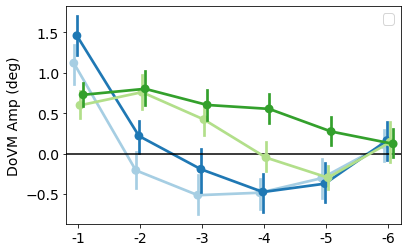

In [20]:
dp=0
xl = [-.2,5.2]
query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str!="-5--1" & pool==False'
sns.pointplot(data=fits_all.query(query_0),hue='condition',x='nb_str',y='ampVM',ci=68,palette='Paired',
              hue_order = ['dot->dot','comp->dot','dot->comp','comp->comp'],dodge=.15)

plt.plot(xl,[0,0],'k')
plt.xlim(xl)
plt.xlabel('')
plt.ylabel('DoVM Amp (deg)')
plt.legend('')
plt.show()

# Stats

In [21]:
# stats for each nb pooled...
pool=False
y_var = 'amp_dummy'
nb_str_view = fits_merge.nb_str.unique()[1:]
cond_check = ['dot->dot','comp->dot','both->dot','dot->comp','comp->comp','both->comp']
nb_str = nb_str_view[0]
this_cond = cond_check[0]
this_query = 'condition==@this_cond & nb_str==@nb_str & drop_prev==0 & pool==@pool' # & subj not in @rep_subj
query_0 = 'condition=="both->dot" & nb_str==@nb_str & drop_prev==0& pool==@pool' # & subj not in @rep_subj
query_1 = 'condition=="both->comp" & nb_str==@nb_str & drop_prev==0& pool==@pool' # & subj not in @rep_subj'

for nb_str in nb_str_view:
    for this_cond in cond_check:
        this_amp = fits_merge.query(this_query)[y_var].values
        this_t = scipy.stats.ttest_1samp(this_amp,0)
        df = len(this_amp)-1
        print(f'NB:{nb_str} {this_cond} t({df})={this_t[0]:.2} (p={this_t[1]:.4})')
    vals = (fits_merge.query(query_0)[y_var].values,fits_merge.query(query_1)[y_var].values)
    this_t = scipy.stats.ttest_rel(*vals)
    print(f'NB:{nb_str} COMP\t t({df})={this_t[0]:.2} (p={this_t[1]:.4})')
    print()



NB:-1 dot->dot t(111)=0.12 (p=0.9014)
NB:-1 comp->dot t(100)=-1.6 (p=0.1193)
NB:-1 both->dot t(100)=-1.8 (p=0.07446)
NB:-1 dot->comp t(100)=-0.59 (p=0.5587)
NB:-1 comp->comp t(110)=1.2 (p=0.2363)
NB:-1 both->comp t(100)=-0.78 (p=0.4376)
NB:-1 COMP	 t(100)=-0.85 (p=0.3996)

NB:-2 dot->dot t(112)=-0.65 (p=0.5154)
NB:-2 comp->dot t(100)=-4.1 (p=9.424e-05)
NB:-2 both->dot t(100)=-4.1 (p=9.807e-05)
NB:-2 dot->comp t(100)=-0.2 (p=0.8411)
NB:-2 comp->comp t(113)=-0.84 (p=0.4028)
NB:-2 both->comp t(100)=-0.31 (p=0.7608)
NB:-2 COMP	 t(100)=-2.7 (p=0.008711)

NB:-3 dot->dot t(112)=-1.7 (p=0.08585)
NB:-3 comp->dot t(100)=-2.1 (p=0.03786)
NB:-3 both->dot t(100)=-2.4 (p=0.02039)
NB:-3 dot->comp t(100)=-0.43 (p=0.6701)
NB:-3 comp->comp t(111)=0.34 (p=0.7334)
NB:-3 both->comp t(100)=0.74 (p=0.4635)
NB:-3 COMP	 t(100)=-2.2 (p=0.03223)

NB:-4 dot->dot t(113)=0.056 (p=0.9556)
NB:-4 comp->dot t(100)=-1.7 (p=0.09827)
NB:-4 both->dot t(100)=-1.5 (p=0.1306)
NB:-4 dot->comp t(100)=-0.47 (p=0.6398)
NB:-4 comp

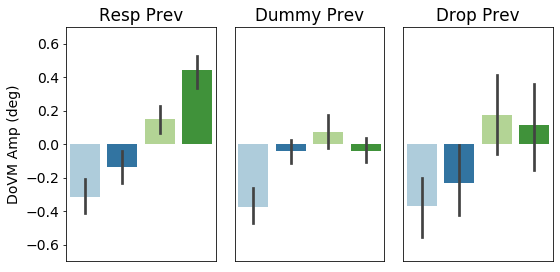

In [22]:
yl = [-1,0.6]
yl = pm*0.7


nb_str = "-5--1"

query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str==@nb_str & pool==False' #+ task_str
orders = (['dot->dot','comp->dot','dot->comp','comp->comp'], ['comp->dot','dot->dot','comp->comp','dot->comp'])
titls = ('Resp Prev','Dummy Prev', 'Drop Prev')

plt.figure(figsize=(8,4))

for ind,(dp,y_var) in enumerate(zip((0,0,1),('ampVM','amp_dummy','ampVM'))):
    plt.subplot(1,3,ind+1)
    this_order = orders[ind%2]
    sns.barplot(data=fits_merge.query(query_0),x='condition',y=y_var,order = this_order,palette='Paired',ci=68)
    plt.xticks([])
    plt.xlabel('')
    plt.ylim(yl)
    if ind==0:
        plt.ylabel('DoVM Amp (deg)')
    else:
        
        plt.yticks([])
        plt.ylabel('')
    plt.title(titls[ind])
plt.tight_layout()
plt.show()


# Figure S5 - Resp start bias and delay 

In [23]:
# need start resp loc for a

S['d_start'] = SDF.wrapRad(S.start_resp-S.correct_resp.values)
subjs_this = S.query('task=="v5"').subj_t.unique()
# tmp = S.query('task=="v5"').copy()
nb = -1 
this_S = get_this_S()


fits_start_resp = pd.DataFrame()
fits_start_resp_delay = pd.DataFrame()
for si,subj in enumerate(subjs_this):
    this_query = 'subj_t==@subj & good & drop_trials==0 & trial>=-@nb & corrected_E.notnull()' # 
    Su = S.query(this_query, engine='python')

    n_inc = len(Su)
    if n_inc<min_trials:
        continue

    vals = tuple(Su.loc[:,['d_start','corrected_E']].values.T)
    this_acc = SDF.circ_var(vals[1])
    slide_bias,slide_var = get_curve_estimates(vals)
    this_coef,_ = get_fit(vals)
    fits_start_resp = fits_start_resp.append({'subj':subj,'task':this_task,'ampVM':this_coef[0]*r2d,
                                'wVM':this_coef[1],#'bVM':this_coef[2],
                              'n_trials':n_inc,
                               'circ_sd':this_acc,
                                'slide_bias':slide_bias,'slide_var':slide_var,
                               },ignore_index=1)

    this_query_2 = 'subj_t==@subj& good & drop_trials==0 & trial>=-@nb & corrected_E.notnull() & delay==@delay & compass==@ci' #  

    for di,delay in enumerate((2,5)):
        for ci in range(2):
            Su = this_S.query(this_query_2, engine='python')
            vals = tuple(Su.loc[:,['d_ori','corrected_E']].values.T)
            this_acc = SDF.circ_var(vals[1])
            
            slide_bias,slide_var = get_curve_estimates(vals)
            this_coef,_ = get_fit(vals)
            fits_start_resp_delay = fits_start_resp_delay.append({'subj':subj,'task':this_task,'ampVM':this_coef[0]*r2d,
                                'wVM':this_coef[1],'delay':delay,'compass':ci,
                              'n_trials':n_inc,
                               'circ_sd':this_acc,
                                'slide_bias':slide_bias,'slide_var':slide_var,
                               },ignore_index=1)


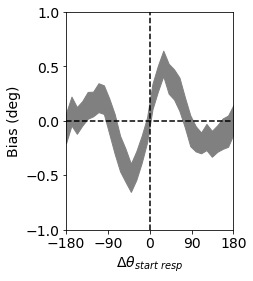

In [24]:
stack_start_bias =  np.stack(fits_start_resp.slide_bias)
plt.figure(figsize=(3,4))
SDF.sem_plot(bns*r2d,stack_start_bias,color='gray')
SDF.d_plot(1,1)
plt.xlabel('$\Delta\\theta_{start~resp}$')
plt.ylabel('Bias (deg)')
plt.show()

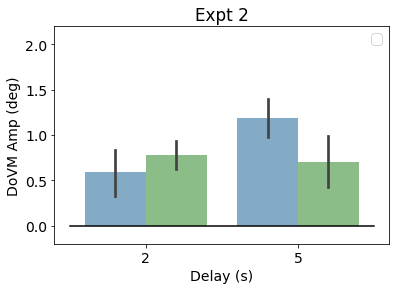

In [25]:
sns.barplot(data=fits_start_resp_delay,hue='compass',x='delay',y='ampVM',palette=cols[1::2],ci=68,alpha=.6)
plt.xticks([0,1],['2','5'])
plt.xlabel('Delay (s)')
plt.legend([]);
plt.title('Expt 2')
plt.ylabel('DoVM Amp (deg)')
plt.ylim([-.2,2.2])
plt.plot([-0.5,1.5],[0,0],'k')
# sav_fig('delay_bias_expt2')
plt.show()

In [26]:
vals0 = (fits_start_resp_delay.query('compass==0 & delay==2').ampVM.values,
        fits_start_resp_delay.query( 'compass==0 & delay==5').ampVM.values)

# vals0 = (fits_start_resp_delay.query('compass==1 & delay==2').circ_sd.values,
#         fits_start_resp_delay.query( 'compass==1 & delay==5').circ_sd.values)

vals1 = (fits_start_resp_delay.query('compass==1 & delay==2').ampVM.values,
        fits_start_resp_delay.query('compass==1 & delay==5').ampVM.values)

d_vals = (vals0[1]-vals0[0],vals1[1]-vals1[0])
scipy.stats.ttest_rel(*d_vals)

print(scipy.stats.ttest_rel(*vals0))
print(scipy.stats.ttest_rel(*vals1))
# scipy.stats.ttest_ind(*vals0)
# difference of difference

d_vals0 = vals0[0]-vals0[1]
d_vals1 = vals1[0]-vals1[1]
print(f'{np.mean(d_vals0):.3}+/- {sem(d_vals0):.3}')
print(f'{np.mean(d_vals1):.3}+/- {sem(d_vals1):.3}')
        

Ttest_relResult(statistic=-1.5597545522944287, pvalue=0.1300505377762184)
Ttest_relResult(statistic=0.23601760084623713, pvalue=0.8151369435519206)
-0.594+/- 0.374
0.0739+/- 0.308


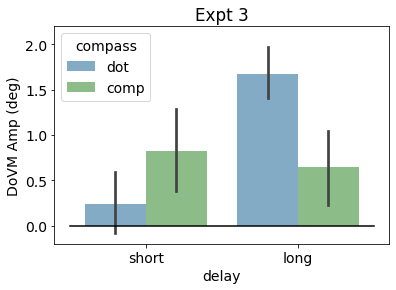

In [27]:
fits_delay = pd.read_parquet('data/fits_expt3_delay.parquet')
this_d = fits_delay.query("nb_str=='-1' & drop_prev==0 & pool==False")
sns.barplot(data=this_d,hue='compass',x='delay',y='ampVM',palette=cols[1::2],ci=68,alpha=.6)
plt.title('Expt 3')
plt.ylabel('DoVM Amp (deg)')
plt.ylim([-.2,2.2])
plt.plot([-0.5,1.5],[0,0],'k')
plt.show()

In [28]:
vals0 = (this_d.query('compass=="dot" & delay=="short"').sigma.values,
        this_d.query( 'compass=="dot" & delay=="long"').sigma.values)
# vals0 = (this_d.query('compass=="compass" & delay=="short"').sigma.values,
#         this_d.query( 'compass=="compass" & delay=="long"').sigma.values)
d_vals0 = vals0[0]-vals0[1]
print(scipy.stats.ttest_rel(*vals0))

print(f'{np.mean(d_vals0):.3}+/- {sem(d_vals0):.3}')

Ttest_relResult(statistic=-3.8954842887030336, pvalue=0.0007290084076112473)
-1.11+/- 0.28


# Control for duplicate subjects (those who participated in >1 experiment)

In [29]:
subj_list = []
for task in task_order:
    _s = fits_merge.query('task==@task').subj.unique()
    s = [ss[:7] for ss in _s]
    subj_list.append(s)
    
l_cat=  np.concatenate(subj_list)
ls_cat = set(l_cat)
print(len(l_cat),len(ls_cat))
# subj count map...
s_cnt = {}
rep_subj= set()
for l in l_cat:
    if l in s_cnt:
        s_cnt[l]+=1
        rep_subj.add(l)
    else:
        s_cnt[l]=1
print(rep_subj)

124 114
{'UCSD136', 'UCSD134', 'UCSD102', 'UCSD131', 'UCSD129', 'UCSD007', 'POOL_RA'}


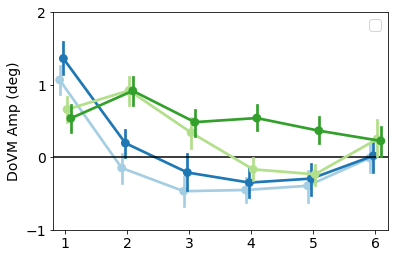

In [30]:
dp=0
xl = [-.2,5.2]
# this_task = tasks[2]
query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str!="-5--1" & subj not in @rep_subj & pool==False'#' & task==@this_task'
sns.pointplot(data=fits_merge.query(query_0),hue='condition',x='nb_str',dodge=.18,
              y='ampVM',ci=68,palette='Paired',hue_order = ['dot->dot','comp->dot','dot->comp','comp->comp'])
plt.plot(xl,[0,0],'k')
plt.xlim(xl)
plt.legend('')
plt.ylim([-1,2.0])
plt.yticks(np.arange(-1,3))
plt.xticks(np.arange(6),np.arange(1,7))
plt.xlabel('')
plt.ylabel('DoVM Amp (deg)')
# sav_fig('Fig_3_timeCourse')
plt.show()


# Figure S7

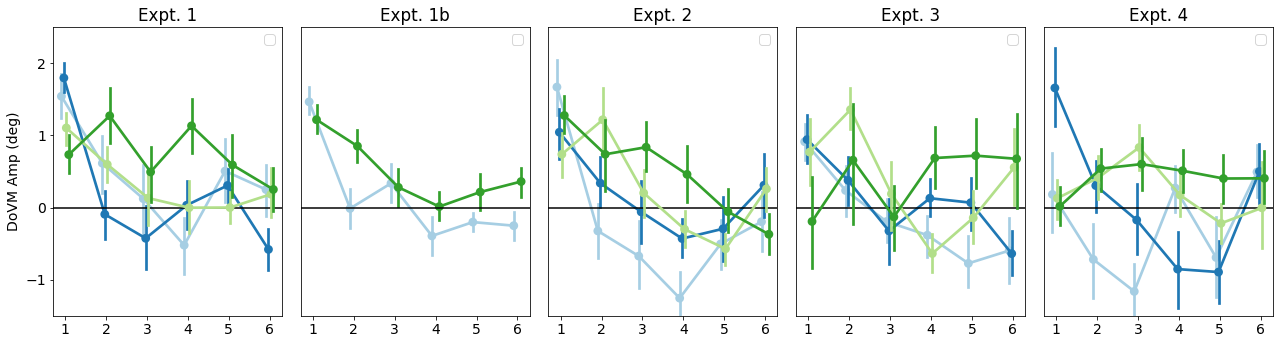

In [31]:
yl_this = (-1.5,2.5)
dp=0
xl = [-.3,5.3]
task_order = [ 'v4','v3', 'v5','expt3', 'v8']
expt_names = ['1','1b','2','3','4']
this_task = tasks[0]
query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str!="-5--1"& task==@this_task & pool==@pool'
plt.figure(figsize=(18,5))
for ti,this_task in enumerate(task_order):
    plt.subplot(1,5,ti+1)
    if this_task=='v3':
        ho = ['dot->dot','comp->comp']
        this_cols = cols[0::3]
    else:
        ho = ['dot->dot','comp->dot','dot->comp','comp->comp']
        this_cols = cols
    pool=False
    sns.pointplot(data=fits_merge.query(query_0),hue='condition',x='nb_str',
              y='ampVM',ci=68,col='task',hue_order=ho,palette=this_cols,dodge=.18)
    plt.ylim([-1,2.0])
    plt.legend('')
    plt.ylim(yl_this)
   
    plt.xticks(np.arange(6),np.arange(1,7))
    plt.plot(xl,[0,0],'k')
    plt.xlabel('')
    plt.xlim(xl)
    
    if ti==0:
        plt.ylabel('DoVM Amp (deg)')
        plt.yticks(np.arange(-1,3))
    else:
        plt.ylabel('')
        plt.yticks([])
    plt.title(f'Expt. {expt_names[ti]}')
plt.tight_layout()
# sav_fig('FigS7')
plt.show()
    

# Figure S6

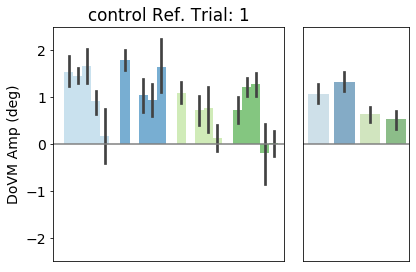

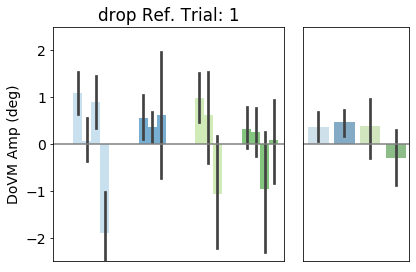

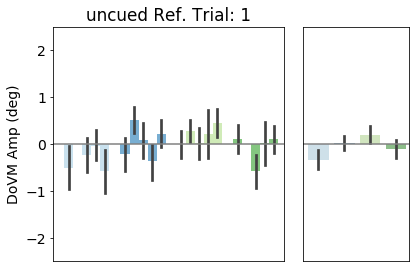

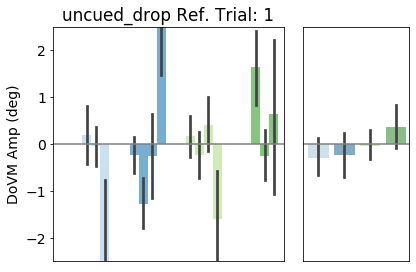

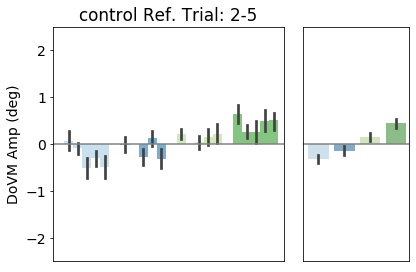

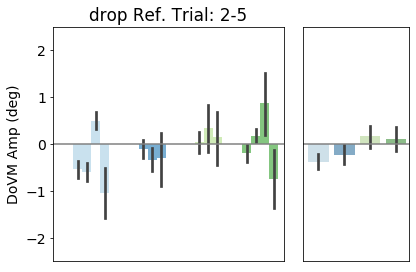

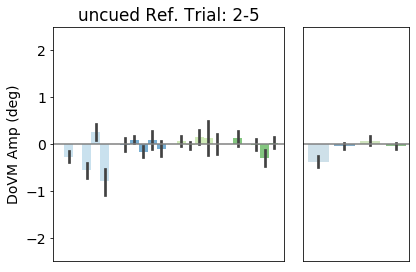

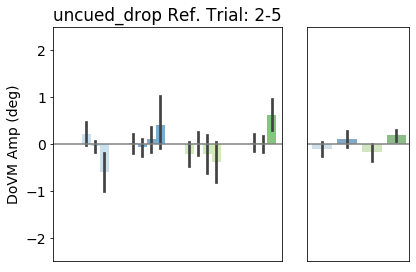

In [32]:
# (0, "-1", "ampVM"), (1, "-1", "ampVM"), (0, "-1", "amp_dummy")
yl = pm*2.5
xl0,xl1 = ([-.6,3.5],[-.6,3.5])
yls = (2.5*pm,2.5*pm)
fig_types = ('control','drop','uncued','uncued_drop')
order_base =  ['dot->dot','comp->dot','dot->comp','comp->comp']
order_dummy = ['comp->dot','dot->dot','comp->comp','dot->comp']
pool=False
query_0 = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str==@nb_str & pool==False '# & n_trials>30'
query_0_pool = 'drop_prev==@dp & compass!="both" & compass_prev!="both" & nb_str==@nb_str & pool==True & shuffle==False'# & n_trials>30'

query_use = query_0
order_use = order_base
nb_ann = ('1','2-5')
for ni,nb_str in enumerate(('-1','-5--1')):

    for fig_type in fig_types:
        order_use = order_base
        if fig_type=='control':
            dp,var_view =  0, 'ampVM'
        elif fig_type=='drop':
            dp,var_view =  1, 'ampVM'
        elif fig_type == 'uncued':
            dp,var_view =  0, 'amp_dummy'
            order_use = order_dummy
        elif fig_type == 'uncued_drop':
            dp,var_view =  1, 'amp_dummy'
            order_use = order_dummy

        plt.figure(figsize=(6,4))
        plt.subplot(1,3,(1,2))
        ax = sns.barplot(data=fits_merge.query(query_use),x='condition',hue='task',y=var_view,ci=68,
                         hue_order=task_order,order=order_use,alpha=.6,)

        for bars in ax.containers:
             for bar, color in zip(bars, cols):
                    bar.set_facecolor(color)
        ax.legend_.remove()
        plt.plot(xl0,[0,0],'gray')
        plt.xlim(xl0)
        plt.title(f'{fig_type} Ref. Trial: {nb_ann[ni]}')
        plt.ylabel('DoVM Amp (deg)')

        plt.ylim(yls[ni])
        plt.xlabel('')
        plt.xticks([])
        plt.subplot(1,3,3)

        sns.barplot(data=fits_merge.query(query_use),x='condition',y=var_view,ci=68,
                         order=order_use,alpha=.6,palette='Paired')
        plt.plot(xl1,[0,0],'gray')
        plt.xlim(xl1)
        plt.ylim(yls[ni])
        plt.xticks([])
        plt.xlabel('')
        plt.yticks([])
        plt.ylabel('')
        plt.tight_layout()
#         sav_fig(f'Pool_{fig_type}_{nb_str}')
        plt.show()

    

In [33]:
# get stats on dot-dot all
nb_str = '-1'
dp=1
query_0 = 'drop_prev==@dp & compass=="dot" & compass_prev=="dot" & nb_str==@nb_str'
y_var = ['ampVM','amp_dummy'][0]

for nb_str in ('-1','-5--1'):
    amps = fits_merge.query(query_0)[y_var].values
    this_t = scipy.stats.ttest_1samp(amps,0)

    print(f'{nb_str}\t t({len(amps)-1})={this_t[0]:.2}, p={this_t[1]:.5} ')

-1	 t(559)=1.7, p=0.089008 
-5--1	 t(585)=-1.6, p=0.10658 


In [34]:
# look @ drop nb=-1, dot->dot for v8 vs everyone else...
fits_merge['both_attended'] = fits_merge.task=='v8'
nb_str='-5--1'
query_0 = 'drop_prev==@dp & compass=="dot" & compass_prev=="dot" & nb_str==@nb_str & both_attended==True'
query_1= 'drop_prev==@dp & compass=="dot" & compass_prev=="dot" & nb_str==@nb_str & both_attended==False'
amps0= fits_merge.query(query_0)[y_var].values
amps1= fits_merge.query(query_1)[y_var].values
print(scipy.stats.ttest_1samp(amps1,0),len(amps1))
print(scipy.stats.ttest_ind(amps1,amps0),len(amps1)+len(amps0))

Ttest_1sampResult(statistic=-0.978279583340154, pvalue=0.32844583628903956) 465
Ttest_indResult(statistic=1.6217684445958398, pvalue=0.10539265515740219) 586


In [35]:
# look at drop nb2-5 expt 3 vs all
dp=0
y_var = ['ampVM','amp_dummy'][1]
nb_str = '-5--1'
query_0 = 'drop_prev==@dp & compass=="dot" & compass_prev=="comp" & nb_str==@nb_str & task=="expt3"'
query_1= 'drop_prev==@dp & compass=="dot" & compass_prev=="comp" & nb_str==@nb_str & task!="expt3"'

amps0= fits_merge.query(query_0)[y_var].values
amps1= fits_merge.query(query_1)[y_var].values
print(scipy.stats.ttest_1samp(amps0,0),len(amps0))
print(scipy.stats.ttest_ind(amps1,amps0),len(amps1)+len(amps0))

Ttest_1sampResult(statistic=1.2158806797986759, pvalue=0.22634003813939033) 125
Ttest_indResult(statistic=-3.063551692263232, pvalue=0.0023045355392639737) 505


# Figure 4

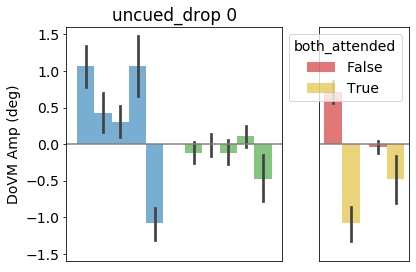

In [36]:
# just make seperate figure for dummy0
query_dummy0 = 'nb_str==@nb_str' # compass_prev=="both" &
order_dummy = ['both->comp','both->dot']
var_view = 'amp_dummy'
nb_str='0'

yl=1.6*pm
fits_merge['both_attended'] = fits_merge.task=='v8'

plt.figure(figsize=(6,4))
plt.subplot(1,3,(1,2))
ax = sns.barplot(data=fits_merge.query(query_dummy0),x='condition',hue='task',y=var_view,ci=68,
                 hue_order=task_order,order=order_dummy,alpha=.6,palette=cols[1::2])

for bars in ax.containers:
     for bar, color in zip(bars, cols[1::2]):
            bar.set_facecolor(color)
ax.legend_.remove()
plt.title(f'{fig_type} {nb_str}')

xl0 = [-.5,1.5]
plt.plot(xl0,[0,0],'gray')
plt.xlim(xl0)

plt.ylim(yl)
plt.xlabel('')
plt.xticks([])
plt.ylabel('DoVM Amp (deg)')
plt.subplot(1,3,3)

sns.barplot(data=fits_merge.query(query_dummy0),x='condition',y=var_view,ci=68,
                 order=order_dummy,alpha=.6,palette='hot',hue='both_attended')
plt.ylim(yl)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

xl1 = [-.5,1.5]
plt.plot(xl1,[0,0],'gray')
plt.xlim(xl1)
plt.tight_layout()
# sav_fig('Pool_uncued_current')
plt.show()


In [37]:
this_d = fits_merge.query(query_dummy0)
comp = 'comp'
dummy_query_1 = 'nb_str=="0" & task==@task & compass==@comp'
for task in task_order:
    this_d = fits_merge.query(dummy_query_1)
    this_amp = this_d.amp_dummy.values
    this_t = scipy.stats.ttest_1samp(this_amp,0)
#     print(this_t)
    print(f'{task}\tt({len(this_amp)-1})={this_t[0]:.2}, p={this_t[1]:.5} ')

v4	t(19)=3.6, p=0.0017168 
v3	t(13)=1.5, p=0.15601 
v5	t(29)=1.4, p=0.16437 
expt3	t(24)=2.5, p=0.017745 
v8	t(29)=-4.8, p=4.0568e-05 


In [38]:
comp = 'comp'
ba=0
dummy_query_2 = 'nb_str=="0" & both_attended==@ba & compass==@comp & pool==False'
vals0 = fits_merge.query(dummy_query_2).amp_dummy.values
ba=1
vals1 = fits_merge.query(dummy_query_2).amp_dummy.values
print(scipy.stats.ttest_ind(vals0,vals1))
print(len(vals0)+len(vals1)-2)

print(scipy.stats.ttest_1samp(vals1,0))

Ttest_indResult(statistic=5.666516087665866, pvalue=1.1466143515478842e-07)
112
Ttest_1sampResult(statistic=-4.692182912284182, pvalue=6.432973808495497e-05)
